In [1]:
#installations
!pip install --upgrade opencv-python mediapipe torch torchvision torchsummary seaborn gtts

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 119MB/s] 


Epoch 1/20
Train Acc: 0.0625, Train Loss: 3.2328
Test Acc: 0.1405, Test Loss: 3.1486
--------------------------------------------------
Epoch 2/20
Train Acc: 0.3229, Train Loss: 3.0464
Test Acc: 0.3058, Test Loss: 2.9348
--------------------------------------------------
Epoch 3/20
Train Acc: 0.5458, Train Loss: 2.7931
Test Acc: 0.4050, Test Loss: 2.5637
--------------------------------------------------
Epoch 4/20
Train Acc: 0.7000, Train Loss: 2.3951
Test Acc: 0.4463, Test Loss: 2.1942
--------------------------------------------------
Epoch 5/20
Train Acc: 0.7312, Train Loss: 1.9873
Test Acc: 0.5537, Test Loss: 1.8559
--------------------------------------------------
Epoch 6/20
Train Acc: 0.8021, Train Loss: 1.5482
Test Acc: 0.6116, Test Loss: 1.5349
--------------------------------------------------
Epoch 7/20
Train Acc: 0.8667, Train Loss: 1.1467
Test Acc: 0.6694, Test Loss: 1.3096
--------------------------------------------------
Epoch 8/20
Train Acc: 0.9021, Train Loss: 0.8355

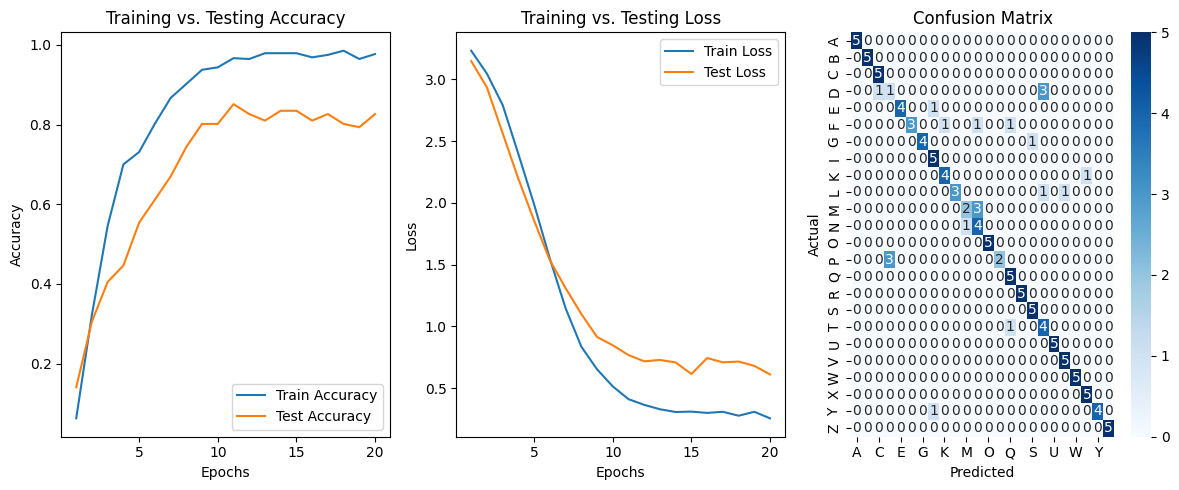

In [2]:
import os
import cv2
import numpy as np
import mediapipe as mp
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix
from PIL import Image
from sklearn.model_selection import train_test_split

# ✅ Update dataset path
dataset_path = "/kaggle/input/all-isl-dataset/All_ISL_Datasets/ISL_Dataset_3"

# ✅ Update class labels (A-Z)
char_to_label = {chr(65 + i): i for i in range(26)}
label_to_char = {v: k for k, v in char_to_label.items()}

# ✅ Initialize MediaPipe Hands
mp_hands = mp.solutions.hands

# ✅ Function to extract hand keypoints
def extract_keypoints(image, max_hands=2):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    keypoints = np.zeros(max_hands * 21 * 3)
    with mp_hands.Hands(static_image_mode=False, max_num_hands=max_hands, min_detection_confidence=0.7) as hands:
        results = hands.process(image_rgb)
        if results.multi_hand_landmarks:
            for h, hand_landmarks in enumerate(results.multi_hand_landmarks[:max_hands]):
                for i, landmark in enumerate(hand_landmarks.landmark):
                    keypoints[h * 21 * 3 + i * 3] = landmark.x
                    keypoints[h * 21 * 3 + i * 3 + 1] = landmark.y
                    keypoints[h * 21 * 3 + i * 3 + 2] = landmark.z
    return keypoints

# ✅ Custom Dataset Class
class ISLDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = cv2.imread(img_path)
        image = cv2.resize(image, (224, 224))
        keypoints = extract_keypoints(image, max_hands=2)
        
        if self.transform:
            image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            image = self.transform(image)
        
        return image, torch.tensor(keypoints, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# ✅ Load Image Paths and Split into Train/Test
image_paths, labels = [], []
for class_name in sorted(os.listdir(dataset_path)):
    if class_name in char_to_label:
        class_dir = os.path.join(dataset_path, class_name)
        for img_name in os.listdir(class_dir):
            image_paths.append(os.path.join(class_dir, img_name))
            labels.append(char_to_label[class_name])

train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

# ✅ Data Transformations
transform = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# ✅ Create Dataset Instances
batch_size = 64
train_dataset = ISLDataset(train_paths, train_labels, transform=transform)
test_dataset = ISLDataset(test_paths, test_labels, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ✅ Define Hybrid Model (EfficientNet + LSTM for Keypoints)
class LSTMFeatureExtractor(nn.Module):
    def __init__(self, input_size=3, hidden_size=128, output_size=64, num_layers=2):
        super(LSTMFeatureExtractor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, keypoints):
        # Reshape keypoints: (batch, 126) -> (batch, 42, 3)
        keypoints_seq = keypoints.view(-1, 42, 3)
        _, (hidden, _) = self.lstm(keypoints_seq)
        # Use the last layer's hidden state
        output = self.fc(hidden[-1])
        return output

class EfficientNetLSTM(nn.Module):
    def __init__(self, num_classes=26):
        super(EfficientNetLSTM, self).__init__()
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        self.efficientnet.classifier = nn.Linear(1280, 128)
        self.lstm_extractor = LSTMFeatureExtractor(input_size=3, hidden_size=128, output_size=64, num_layers=2)
        self.final_fc = nn.Linear(128 + 64, num_classes)

    def forward(self, image, keypoints):
        img_features = self.efficientnet(image)
        keypoint_features = self.lstm_extractor(keypoints)
        combined = torch.cat((img_features, keypoint_features), dim=1)
        return self.final_fc(combined)

# ✅ Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNetLSTM(num_classes=26).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0003, weight_decay=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)

# Lists to store metrics for plotting
train_acc_list, test_acc_list = [], []
train_loss_list, test_loss_list = [], []

# For confusion matrix (we will accumulate predictions from the final epoch)
final_preds, final_labels = [], []

# ✅ Training Loop with Test Evaluation at Each Epoch
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    train_correct, train_total, running_train_loss = 0, 0, 0.0
    
    for images, keypoints, labels in train_loader:
        images, keypoints, labels = images.to(device), keypoints.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images, keypoints)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        running_train_loss += loss.item()
    
    train_acc = train_correct / train_total
    train_loss = running_train_loss / len(train_loader)
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    
    # Evaluate on the test set at the end of each epoch
    model.eval()
    test_correct, test_total, running_test_loss = 0, 0, 0.0
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for images, keypoints, labels in test_loader:
            images, keypoints, labels = images.to(device), keypoints.to(device), labels.to(device)
            outputs = model(images, keypoints)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_acc = test_correct / test_total
    test_loss = running_test_loss / len(test_loader)
    test_acc_list.append(test_acc)
    test_loss_list.append(test_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Acc: {train_acc:.4f}, Train Loss: {train_loss:.4f}")
    print(f"Test Acc: {test_acc:.4f}, Test Loss: {test_loss:.4f}")
    print("-" * 50)
    
    # Save final predictions from the last epoch for confusion matrix
    if epoch == num_epochs - 1:
        final_preds = all_preds
        final_labels = all_labels
        
    scheduler.step()

# ✅ Save the trained model
torch.save(model.state_dict(), "EfficientNetLSTM_ISL_3.pth")
print("Updated Model saved as 'EfficientNetLSTM_ISL_3.pth'.")

# ✅ Plot Training vs. Testing Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs+1), train_acc_list, label="Train Accuracy")
plt.plot(range(1, num_epochs+1), test_acc_list, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs. Testing Accuracy")

# ✅ Plot Training vs. Testing Loss
plt.subplot(1, 3, 2)
plt.plot(range(1, num_epochs+1), train_loss_list, label="Train Loss")
plt.plot(range(1, num_epochs+1), test_loss_list, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs. Testing Loss")

# ✅ Plot Confusion Matrix using final predictions
unique_labels = sorted(set(final_labels))
class_names = [label_to_char[i] for i in unique_labels]
cm = confusion_matrix(final_labels, final_preds, labels=unique_labels)
plt.subplot(1, 3, 3)
sns.heatmap(pd.DataFrame(cm, index=class_names, columns=class_names), annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


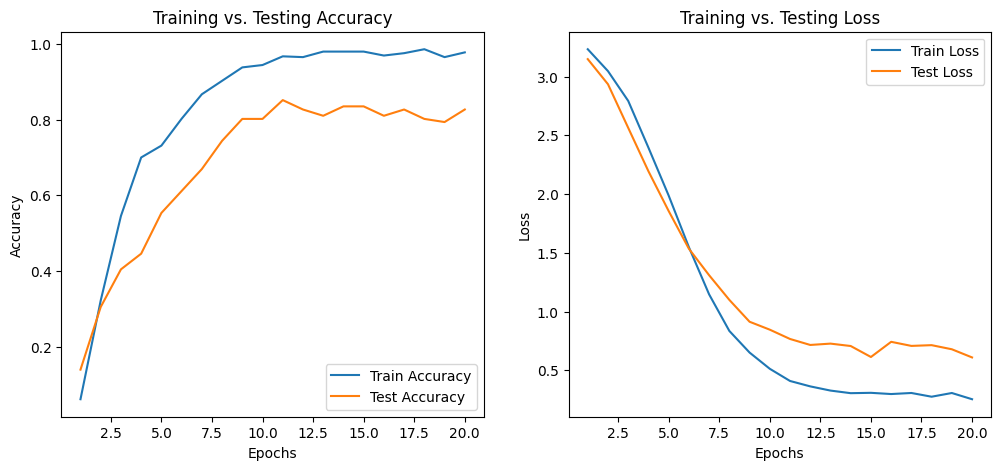

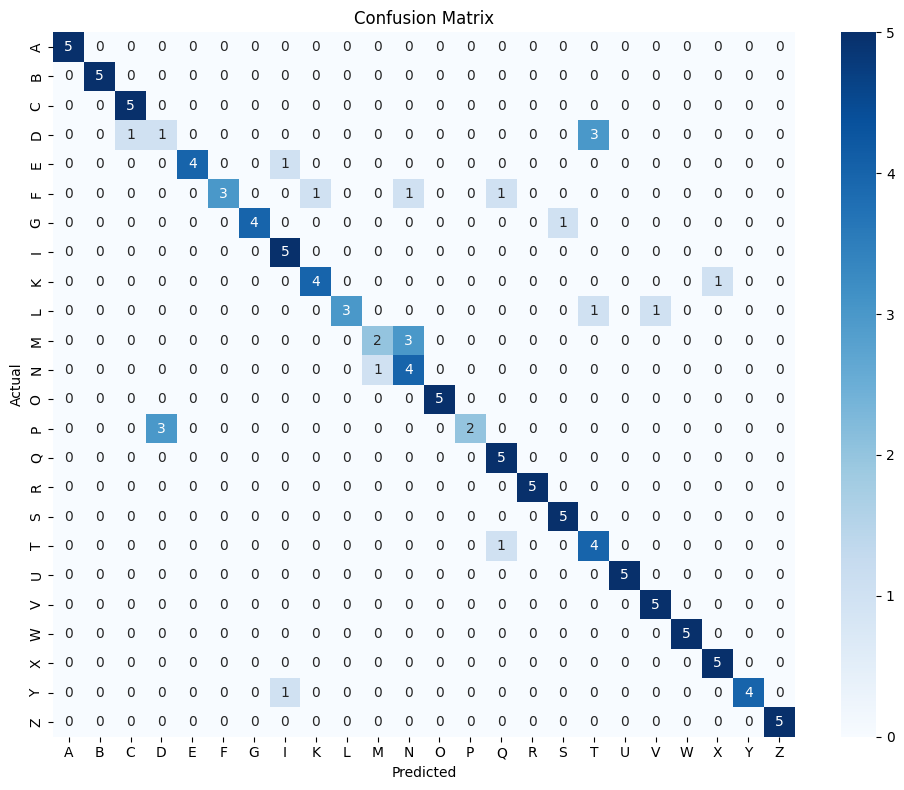

In [12]:
# ✅ Plot Training vs. Testing Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_acc_list, label="Train Accuracy")
plt.plot(range(1, num_epochs+1), test_acc_list, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs. Testing Accuracy")

# ✅ Plot Training vs. Testing Loss
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_loss_list, label="Train Loss")
plt.plot(range(1, num_epochs+1), test_loss_list, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs. Testing Loss")

# ✅ Plot Confusion Matrix using final predictions
unique_labels = sorted(set(final_labels))
class_names = [label_to_char[i] for i in unique_labels]
cm = confusion_matrix(final_labels, final_preds, labels=unique_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(pd.DataFrame(cm, index=class_names, columns=class_names), annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

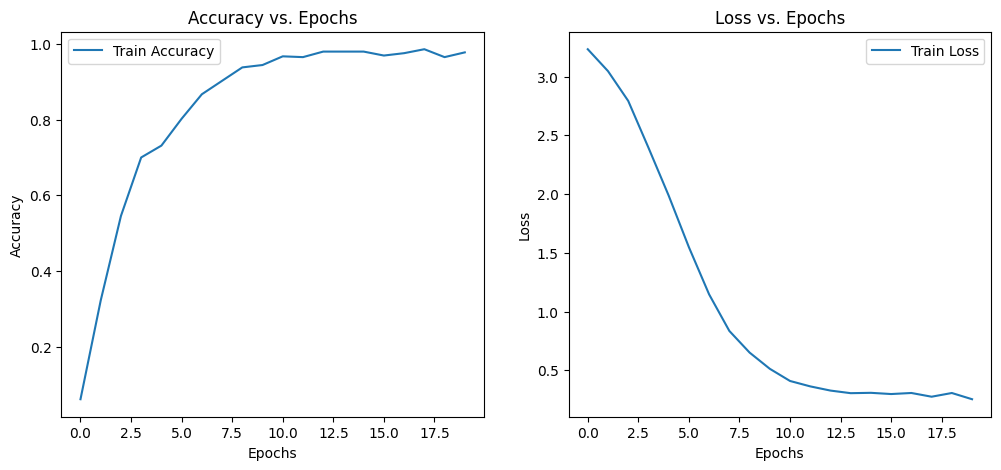

In [3]:
# ✅ Plot Training Progress
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc_list, label="Train Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy vs. Epochs")

plt.subplot(1, 2, 2)
plt.plot(train_loss_list, label="Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs. Epochs")
plt.show()

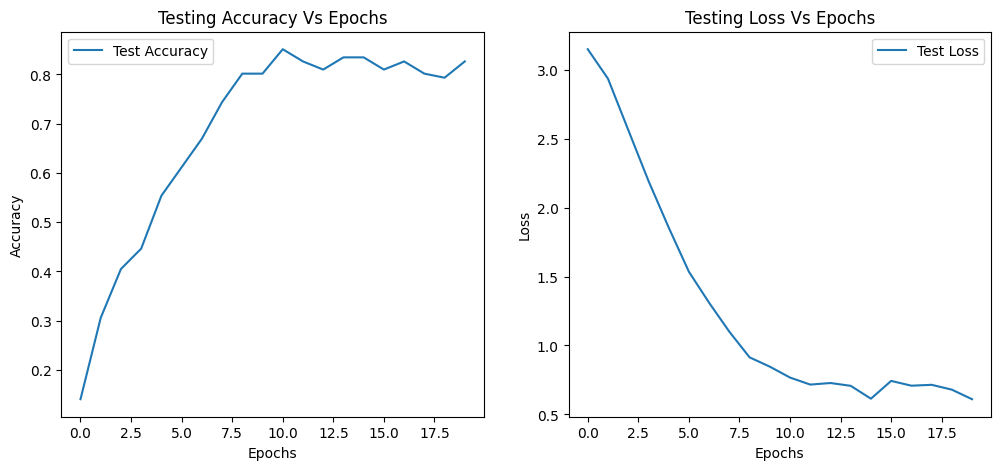

In [4]:
# ✅ Plot Training Progress for Loss and Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(test_acc_list, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Testing Accuracy Vs Epochs")

plt.subplot(1, 2, 2)
plt.plot(test_loss_list, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Testing Loss Vs Epochs")
plt.show()

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Calculate evaluation metrics using the final predictions and labels from the test set
acc = accuracy_score(final_labels, final_preds)
precision = precision_score(final_labels, final_preds, average='macro')
recall = recall_score(final_labels, final_preds, average='macro')
f1 = f1_score(final_labels, final_preds, average='macro')

# Generate a detailed classification report mapping numeric labels to characters
target_names = [label_to_char[i] for i in sorted(set(final_labels))]
report = classification_report(final_labels, final_preds, target_names=target_names)

print("Evaluation Metrics:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1 Score (macro): {f1:.4f}")
print("\nClassification Report:")
print(report)


Evaluation Metrics:
Accuracy: 0.8264
Precision (macro): 0.8533
Recall (macro): 0.8292
F1 Score (macro): 0.8213

Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00         5
           B       1.00      1.00      1.00         5
           C       0.83      1.00      0.91         5
           D       0.25      0.20      0.22         5
           E       1.00      0.80      0.89         5
           F       1.00      0.50      0.67         6
           G       1.00      0.80      0.89         5
           I       0.71      1.00      0.83         5
           K       0.80      0.80      0.80         5
           L       1.00      0.60      0.75         5
           M       0.67      0.40      0.50         5
           N       0.50      0.80      0.62         5
           O       1.00      1.00      1.00         5
           P       1.00      0.40      0.57         5
           Q       0.71      1.00      0.83         5


In [11]:
import os
import cv2
import torch
import numpy as np
import mediapipe as mp
import torchvision.transforms as transforms
from PIL import Image
from gtts import gTTS
import IPython.display as ipd  # For playing audio in Kaggle Notebook
import torchvision.models as models
import torch.nn as nn

# ✅ Define Constants
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "/kaggle/working/EfficientNetLSTM_ISL_3.pth"  # Updated model path for new dataset

# ✅ Define the EfficientNetLSTM model (module names match saved state dict)
class LSTMFeatureExtractor(nn.Module):
    def __init__(self, input_size=3, hidden_size=128, output_size=64, num_layers=2):
        super(LSTMFeatureExtractor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, keypoints):
        # Reshape keypoints: (batch, 126) -> (batch, 42, 3)
        keypoints_seq = keypoints.view(-1, 42, 3)
        _, (hidden, _) = self.lstm(keypoints_seq)
        output = self.fc(hidden[-1])
        return output

class EfficientNetLSTM(nn.Module):
    def __init__(self, num_classes=26):
        super(EfficientNetLSTM, self).__init__()
        # EfficientNet-B0 backbone (pretrained)
        self.efficientnet = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        # Replace classifier with a linear layer to get 128-d image features
        self.efficientnet.classifier = nn.Linear(1280, 128)
        # LSTM feature extractor with submodule name 'lstm_extractor'
        self.lstm_extractor = LSTMFeatureExtractor(input_size=3, hidden_size=128, output_size=64, num_layers=2)
        # Final classification layer after concatenating image and keypoint features
        self.final_fc = nn.Linear(128 + 64, num_classes)
    
    def forward(self, image, keypoints):
        img_features = self.efficientnet(image)  # Shape: (batch, 128)
        keypoint_features = self.lstm_extractor(keypoints)  # Expecting keys like "lstm_extractor.lstm.weight_ih_l0" etc.
        combined = torch.cat((img_features, keypoint_features), dim=1)
        return self.final_fc(combined)

# ✅ Load Model
model = EfficientNetLSTM(num_classes=26).to(device)  # Adjusted for A-Z classes
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    print("Model loaded successfully.")
else:
    print(f"Error: Model file not found at {model_path}")

# ✅ Character Mappings
label_to_char = {i: chr(65 + i) for i in range(26)}  # A-Z mapping

# ✅ Initialize MediaPipe
mp_hands = mp.solutions.hands

def extract_keypoints(image, max_hands=2):
    """Extracts keypoints from the image using MediaPipe Hands."""
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    keypoints = np.zeros(max_hands * 21 * 3)  # Pre-allocate keypoints array
    with mp_hands.Hands(static_image_mode=False, max_num_hands=max_hands, min_detection_confidence=0.7) as hands:
        results = hands.process(image_rgb)
        if results.multi_hand_landmarks:
            for h, hand_landmarks in enumerate(results.multi_hand_landmarks[:max_hands]):
                for i, landmark in enumerate(hand_landmarks.landmark):
                    keypoints[h * 21 * 3 + i * 3] = landmark.x
                    keypoints[h * 21 * 3 + i * 3 + 1] = landmark.y
                    keypoints[h * 21 * 3 + i * 3 + 2] = landmark.z
    return keypoints

# ✅ Define Image Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

# ✅ Get Image Paths from User Input
# For this example, we use a fixed list of image paths.
dataset_path = "/kaggle/input/all-isl-dataset/All_ISL_Datasets/ISL_Dataset_3/"
input_images = [
    os.path.join(dataset_path, "A", "A (1).jpg"),
    os.path.join(dataset_path, "B", "B (1).jpg"),
    os.path.join(dataset_path, "C", "C (1).jpg")
]

# ✅ Perform Prediction
predictions = []
for img_path in input_images:
    image = cv2.imread(img_path)
    if image is None:
        print(f"Error: Could not read image at {img_path}")
        continue

    # Convert BGR to RGB and create a PIL image for transformation
    image_rgb = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    image_tensor = transform(image_rgb).unsqueeze(0).to(device)  # Add batch dimension

    # Extract keypoints from the original image
    keypoints = extract_keypoints(image, max_hands=2)
    keypoints_tensor = torch.tensor(keypoints, dtype=torch.float32).unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        output = model(image_tensor, keypoints_tensor)
        predicted_label = torch.argmax(output, dim=1).item()
        predicted_char = label_to_char[predicted_label]
        predictions.append(predicted_char)

    print(f"Predicted Character for {os.path.basename(img_path)}: {predicted_char}")

# ✅ Convert Predicted Text to Speech
if predictions:
    predicted_text = "".join(predictions)
    print(f"\nFinal Predicted Text: {predicted_text}")
    tts = gTTS(predicted_text)
    tts.save("predicted_audio.mp3")
    ipd.display(ipd.Audio("predicted_audio.mp3"))  # Play in Kaggle Notebook
else:
    print("No predictions were made.")


Model loaded successfully.
Predicted Character for A (1).jpg: A
Predicted Character for B (1).jpg: B
Predicted Character for C (1).jpg: C

Final Predicted Text: ABC
